In [1]:
# from data.loader import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
from typing import Dict

# import yfinance as yf

In [2]:
# import yfinance as yf
# import pandas as pd

# # Step 1: Download BTC and ETH data
# tickers = ['BTC-USD', 'ETH-USD']
# data = yf.download(tickers, start='2018-01-01', end='2025-01-01', group_by='ticker')

# # Step 2: Flatten MultiIndex columns
# data.columns = ['_'.join(col).strip() for col in data.columns.values]

# # Step 3: Separate into BTC and ETH DataFrames
# btc_data = data[[col for col in data.columns if 'BTC-USD' in col]].copy()
# eth_data = data[[col for col in data.columns if 'ETH-USD' in col]].copy()

# # Step 4: Clean up column names
# btc_data.columns = [col.replace('BTC-USD_', '') for col in btc_data.columns]
# eth_data.columns = [col.replace('ETH-USD_', '') for col in eth_data.columns]

# # Step 5: Add 'Date' column from index
# btc_data = btc_data.reset_index()
# eth_data = eth_data.reset_index()

# # Step 6: Save to CSV
# btc_data.to_csv('btc_data.csv', index=False)
# eth_data.to_csv('eth_data.csv', index=False)

# print("✅ BTC and ETH data saved to 'btc_data.csv' and 'eth_data.csv'")
# data.reset_index()

fees = 0.0006

In [3]:
BTC = pd.read_csv('btc_data.csv')
BTC.Date = pd.to_datetime(BTC.Date)
BTC

,Date,Open,High,Low,Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072
...,...,...,...,...,...,...
2552,2024-12-27,95704.976562,97294.843750,93310.742188,94164.859375,52419934565
2553,2024-12-28,94160.187500,95525.898438,94014.289062,95163.929688,24107436185
2554,2024-12-29,95174.054688,95174.875000,92881.789062,93530.226562,29635885267
2555,2024-12-30,93527.195312,94903.320312,91317.132812,92643.210938,56188003691


In [4]:
BTC_2020 = BTC[BTC.Date.dt.year == 2020].reset_index(drop=True)
BTC_2020

,Date,Open,High,Low,Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095
...,...,...,...,...,...,...
361,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,66479895605
362,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,49056742893
363,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,45265946774
364,2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,51287442704


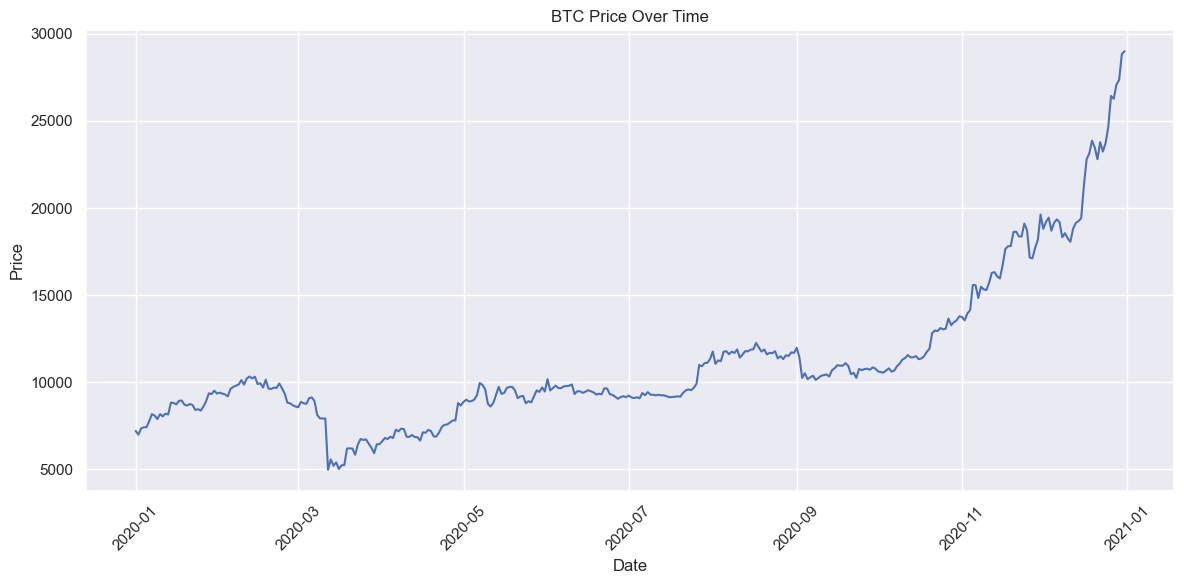

In [5]:
sns.set(style="darkgrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=BTC_2020.Date, y=BTC_2020.Close)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Over Time')

# Rotate dates for readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
BTC_2020

,Date,Open,High,Low,Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095
...,...,...,...,...,...,...
361,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,66479895605
362,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,49056742893
363,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,45265946774
364,2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,51287442704


In [7]:
netflow = pd.read_csv('netflow.csv')
netflow.Date = pd.to_datetime(netflow.Date, unit='ms').dt.date
netflow.Date = pd.to_datetime(netflow.Date)
netflow.dtypes

Date             datetime64[ns]
NetflowVolume           float64
dtype: object

In [8]:
netflow_2020 = netflow[netflow.Date.dt.year == 2020].reset_index(drop=True)

In [9]:
netflow_2020.drop_duplicates()
netflow_2020

,Date,NetflowVolume
0,2020-01-01,3364.505442
1,2020-01-01,1853.135410
2,2020-01-03,2897.774446
3,2020-01-04,5639.604847
4,2020-01-04,1102.205108
...,...,...
361,2020-12-27,11209.549776
362,2020-12-27,-4306.674691
363,2020-12-29,-9083.440257
364,2020-12-30,-5621.675550


In [10]:
data = BTC_2020.merge(netflow_2020.NetflowVolume, left_index=True, right_index=True)
data.dtypes

Date             datetime64[ns]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
NetflowVolume           float64
dtype: object

In [11]:
data['price_change'] = data.Close.pct_change()

In [12]:
# def z_score(data, window):
#     data['price_change'] = data.Close.pct_change()
#     roll = data.rolling(window, min_periods=1)
#     mean = roll.mean()
#     std = roll.std()

#     return (mean - data)/ std

def z_score(data, window, target):
    data['price_change'] = data['Close'].pct_change()
    roll = data[target].rolling(window=window, min_periods=1)
    mean = roll.mean()
    std = roll.std()

    return (data[target] - mean) / std

data['z_score'] = z_score(data, 14, 'NetflowVolume')

In [13]:
import math

def generate_position(data, threshold):
    z = data.z_score
    positions = [0]

    # high netflow volume = sell
    for score in z:
        if math.isnan(score):
            continue
        
        if score > threshold:
            position = -1
        else:
            position = 1
            
        positions.append(position)
        
    positions_series = pd.Series(positions)
    data['positions'] = positions_series  

    data['trades'] = abs(data.positions - data.positions.shift(1))

    return data

position_data = generate_position(data, 1)


In [14]:
def calc_metrics(data, fees, window):

    p_change = data.price_change
    position = data.positions.shift(1)
    trade = data.trades

    pnl = p_change*position-trade*fees
    data['pnl']= pnl

    data['equity'] = pnl.cumsum()

    avg_pnl = pnl.sum()/pnl.count()
    sharp_ratio = avg_pnl/pnl.std() * math.sqrt(365)
    
    trade_per_interval = data.trades.sum()/ data.trades.count()

    # drawdown = 
    
    currmax = data.equity.cummax()
    daily_drawdown = data.equity - currmax 

    data['drawdown'] = daily_drawdown
    MDD = daily_drawdown.min()

    # print(MDD)
    return data, sharp_ratio, trade_per_interval, MDD

calc_data, sharp_ratio, trade_per_interval, MDD = calc_metrics(position_data, fees, 14)

In [15]:
print(f"Sharp Ratio: {sharp_ratio}\nTrade per Interval: {trade_per_interval}\nMDD: {MDD}")

Sharp Ratio: 1.0591499853523587
Trade per Interval: 0.4410958904109589
MDD: -0.87419438610939


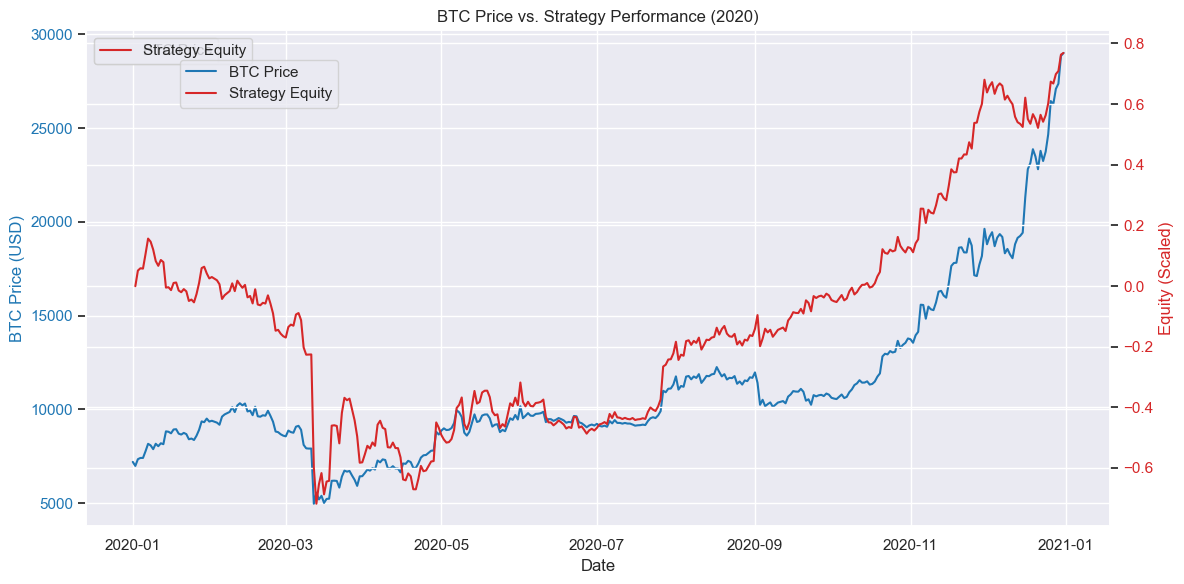

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot BTC Price (Left Y-axis)
color = 'tab:blue'
sns.lineplot(x=BTC_2020.Date, y=BTC_2020.Close, ax=ax1, color=color, label='BTC Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary axis for Equity
ax2 = ax1.twinx()
color = 'tab:red'
sns.lineplot(x=calc_data.Date, y=calc_data.equity, ax=ax2, color=color, label='Strategy Equity')
ax2.set_ylabel('Equity (Scaled)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and format
plt.title('BTC Price vs. Strategy Performance (2020)')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

# Rotate dates and adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
BTC_2022 = BTC[BTC.Date.dt.year == 2022].reset_index(drop=True)
BTC_2022

,Date,Open,High,Low,Close,Volume
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,24582667004
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,27951569547
2,2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,33071628362
3,2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,42494677905
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,36851084859
...,...,...,...,...,...,...
360,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239
361,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920
362,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,14472237479
363,2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,15929162910


In [18]:
reddit2022 = pd.read_csv('reddit_2022.csv')
btc_reddit2022 = reddit2022[reddit2022.subject=='bitcoin'].copy()
text_data = btc_reddit2022[['date', 'title']].reset_index(drop=True)

In [19]:
!pip install transformers torch


In [20]:
from transformers import pipeline
import pandas as pd

# Load pipeline once
sentiment_pipeline = pipeline("sentiment-analysis")

# Modified function to return signed score
def sentiment_score(text):
    result = sentiment_pipeline(text)[0]
    score = result['score']
    if result['label'] == 'NEGATIVE':
        return -round(score, 4)
    else:
        return round(score, 4)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

c:\Users\adam arbain\miniconda3\envs\quant_trading\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adam arbain\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [21]:
text_data['sentiment_score'] = text_data['title'].apply(sentiment_score)
daily_sentiment = text_data.groupby('date')['sentiment_score'].mean().reset_index()

In [22]:
daily_sentiment
daily_sentiment = daily_sentiment.rename(columns={
    'date': 'Date',
})


In [23]:
daily_sentiment.Date = pd.to_datetime(pd.to_datetime(daily_sentiment.Date, errors='coerce').dt.date)
daily_sentiment.dtypes

Date               datetime64[ns]
sentiment_score           float64
dtype: object

In [24]:
nlp_example = BTC_2022.merge(daily_sentiment, on='Date')

In [25]:
nlp_example

,Date,Open,High,Low,Close,Volume,sentiment_score
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,24582667004,-0.998200
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,27951569547,-0.546526
2,2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,33071628362,-0.330277
3,2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,42494677905,-0.790864
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,36851084859,-0.200740
...,...,...,...,...,...,...,...
137,2022-12-08,16847.349609,17267.916016,16788.783203,17233.474609,20496603770,-0.592000
138,2022-12-09,17232.148438,17280.546875,17100.835938,17133.152344,20328426366,-0.733319
139,2022-12-10,17134.220703,17216.826172,17120.683594,17128.724609,12706781969,-0.803595
140,2022-12-11,17129.710938,17245.634766,17091.820312,17104.193359,14122486832,-0.997167


In [26]:
nlp_example.iloc[-2]

Date               2022-12-11 00:00:00
Open                      17129.710938
High                      17245.634766
Low                       17091.820312
Close                     17104.193359
Volume                     14122486832
sentiment_score              -0.997167
Name: 140, dtype: object

In [27]:
def z_score(data, window, target):
    data['price_change'] = data['Close'].pct_change()
    roll = data[target].rolling(window=window, min_periods=1)
    mean = roll.mean()
    std = roll.std()

    return (data[target] - mean) / std

# data['z_score'] = z_score(data.NetflowVolume, 14)

In [28]:
nlp_example['z_score'] = z_score(nlp_example, 14,'sentiment_score')
position_data = generate_position(nlp_example, 1)
calc_data, sharp_ratio, trade_per_interval, MDD = calc_metrics(position_data, fees, 14)


In [29]:
print(f"Sharp Ratio: {sharp_ratio}\nTrade per Interval: {trade_per_interval}\nMDD: {MDD}")

Sharp Ratio: -2.382835343197121
Trade per Interval: 0.46099290780141844
MDD: -1.0334539076012155


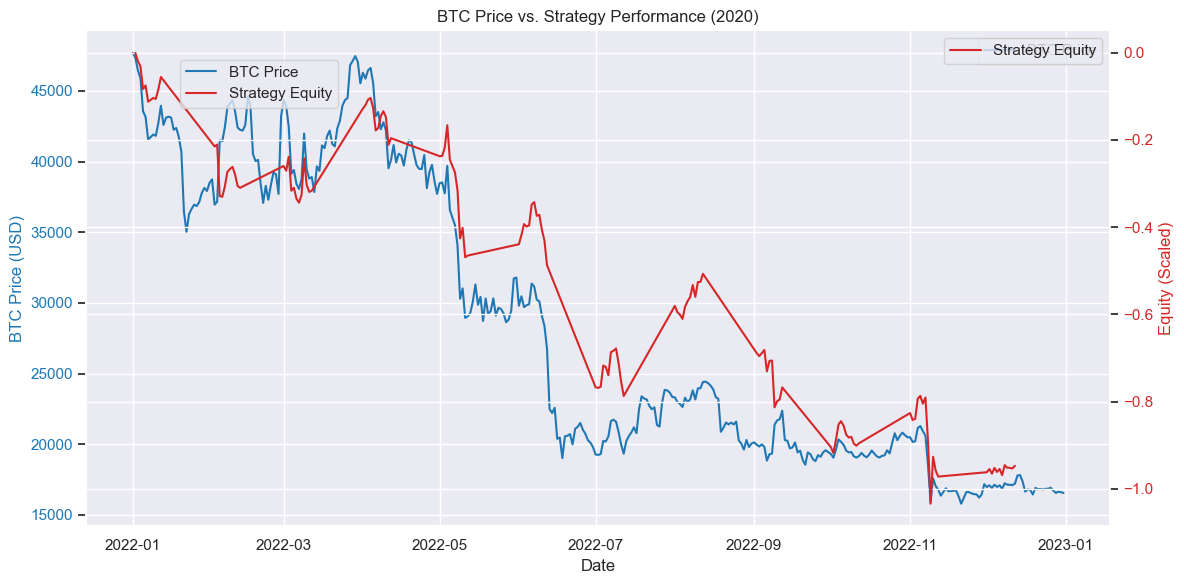

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot BTC Price (Left Y-axis)
color = 'tab:blue'
sns.lineplot(x=BTC_2022.Date, y=BTC_2022.Close, ax=ax1, color=color, label='BTC Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary axis for Equity
ax2 = ax1.twinx()
color = 'tab:red'
sns.lineplot(x=calc_data.Date, y=calc_data.equity, ax=ax2, color=color, label='Strategy Equity')
ax2.set_ylabel('Equity (Scaled)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and format
plt.title('BTC Price vs. Strategy Performance (2020)')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))

# Rotate dates and adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()